In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [2]:
path = PureWindowsPath(os.getcwd() + "\\data\\input\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus["category_bin"] = np.select([corpus["category"] == "philosophy"], [1], default=0)
corpus = corpus.sample(frac=1).reset_index(drop=True)
# corpus["category_bin"] = (corpus["category_bin"] == "philosophy")
# corpus

#preprocessing qui aurait du etre fait avant :
#enlever les retours a la ligne
corpus.replace("\\n", " ", regex=True, inplace=True)

#supprimer les doublons
print("corpus.shape =", corpus.shape)
corpus.drop_duplicates("message", inplace=True, keep="first")
print("corpus.shape =", corpus.shape)

# corpus.shape = (4007, 6) si False
# corpus.shape = (4649, 6) si first


corpus.shape = (8228, 6)
corpus.shape = (4649, 6)


In [3]:
zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())

(1823, 6)
0    1823
1    1823
Name: category_bin, dtype: int64


In [5]:
from sklearn.svm import SVC

model = SVC()
X = corpus["message_preprocessed"]
y = corpus["category"]
# y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# y_train.value_counts()
# print(indices_train, indices_test)
# indices_test
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
model.fit(X_train_tfidf, y_train)

SVC()

In [28]:
# Poids globaux (dans le corpus) des mots tfidf
print("X_train_tfidf.shape =", X_train_tfidf.shape)
n_words = X_train_tfidf.shape[1]
scores_tfidf = pd.DataFrame({"id":range(n_words), "words":tfidf_vectorizer.get_feature_names(), "idf":tfidf_vectorizer.idf_})
scores_tfidf = scores_tfidf.sort_values("idf", ascending=False)
print("moyenne des poids idf =", np.mean(scores_tfidf["idf"]))
print("ecart-type des poids idf =", np.std(scores_tfidf["idf"]))
with pd.option_context("display.max_rows", 100):
    display(scores_tfidf)
# scores_tfidf.to_csv("./data/output/scores_tfidf_train.csv")

X_train_tfidf.shape = (2442, 9625)
moyenne des poids idf = 7.527880934031857
ecart-type des poids idf = 0.8765646759148581


c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,id,words,idf
0,0,aaaayaajpgpadqthechildofthecovenantorhowchristianparentsshouldtrainuptheirhouseholds,8.107835
5264,5264,malversation,8.107835
5282,5282,manifestaient,8.107835
5281,5281,maniera,8.107835
5279,5279,mangez,8.107835
...,...,...,...
1362,1362,cette,2.860811
9603,9603,être,2.711937
6421,6421,plus,2.711937
1625,1625,comme,2.656796


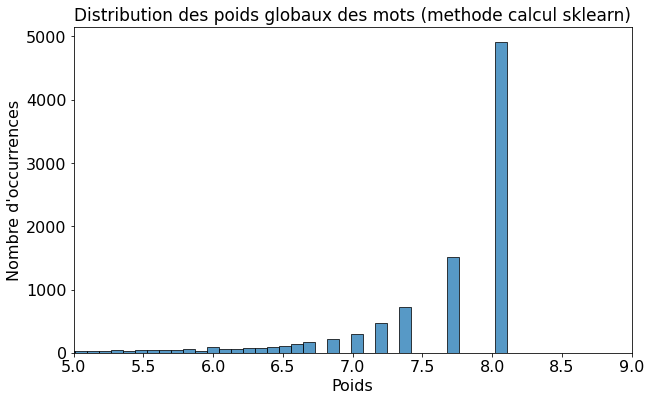

In [29]:
# Distribution des poids globaux des mots (calcules avec sklearn)
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution.png")
path = path.as_posix()

sb.histplot(data=scores_tfidf, x="idf")
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids globaux des mots (methode calcul sklearn)", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(5, 9)
plt.savefig(path)
plt.show()

In [30]:
# Calcul manuel des poids
print("X_train_tfidf.shape =", X_train_tfidf.shape)
words_weights = X_train_tfidf.sum(axis=0)
print("words_weights.shape =", words_weights.shape)
print(words_weights)
print(words_weights.shape)
words_weights = np.ravel(words_weights)
print(words_weights)
print(words_weights.shape)
# words_weights[:10]
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.unique(words_weights).shape
np.max(words_weights)
np.min(words_weights)
print("words_weights.shape =", words_weights.shape)
words_weights

X_train_tfidf.shape = (2442, 9625)
words_weights.shape = (1, 9625)
[[0.286 0.178 0.595 ... 0.139 0.062 0.139]]
(1, 9625)
[0.286 0.178 0.595 ... 0.139 0.062 0.139]
(9625,)
words_weights.shape = (9625,)


array([0.286, 0.178, 0.595, ..., 0.139, 0.062, 0.139])

In [31]:
# scores_tfidf["manuel_weights"] = words_weights
print("corpus.shape =", corpus.shape)
print("scores_tfidf.shape =", scores_tfidf.shape)
scores_tfidf

corpus.shape = (3646, 6)
scores_tfidf.shape = (9625, 3)


,id,words,idf
0,0,aaaayaajpgpadqthechildofthecovenantorhowchristianparentsshouldtrainuptheirhouseholds,8.107835
5264,5264,malversation,8.107835
5282,5282,manifestaient,8.107835
5281,5281,maniera,8.107835
5279,5279,mangez,8.107835
...,...,...,...
1362,1362,cette,2.860811
9603,9603,être,2.711937
6421,6421,plus,2.711937
1625,1625,comme,2.656796


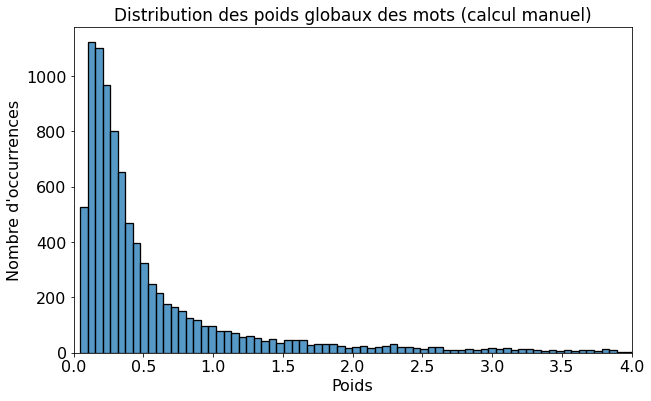

In [35]:
# Distribution des poids globaux des mots (calcules avec a la main)
# Pour chaque phrase, y a-t-il beaucoup de mots qui ont ete trouves et qui ont influences positivement la prediction ?
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution_manuel.png")
path = path.as_posix()

# sb.histplot(words_weights[:100000])
sb.histplot(words_weights, edgecolor="black", linewidth=1.3)
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids globaux des mots (calcul manuel)", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 4)
plt.savefig(path)
plt.show()

In [133]:
# Calcul des poids locaux des mots (poids des mots pour chaque document)
threshold_score = 4.5
col_top_words = [] #liste des top words pour chaque exemple du corpus (partie train)

feature_names = tfidf_vectorizer.get_feature_names_out()
X_train_tfidf_arr = X_train_tfidf.toarray()
idx_vocab = np.argsort(X_train_tfidf_arr, axis=1)
vocab = tfidf_vectorizer.vocabulary_
vocab_inv = {v: k for k, v in vocab.items()}
idx_top_words = idx_vocab[:,-10:]
idx_top_words = np.flip(idx_top_words, axis=1)
# with np.printoptions(threshold=np.inf):
#     print(np.around(np.take_along_axis(X_train_tfidf_arr, idx_top_words, axis=1), 3))

col_top_words = []
# col_idf = []
# avant : for row in idx_top_words
for idx_row in range(len(idx_top_words)):
    # print("row =", row)
    row_matrix_top_words_idx = idx_top_words[idx_row]
    doc_top_words = []
    for idx_word in row_matrix_top_words_idx:
        # print("idx_word =", idx_word)
        word = vocab_inv[idx_word]
        score = str(round(X_train_tfidf_arr[idx_row, idx_word], 3))
        # print("word =", word)
        # doc_top_words.append(word)
        doc_top_words.append(word + " (" + score + ")")
    col_top_words.append(doc_top_words)

df_train = pd.DataFrame(X_train_tfidf_arr, columns = feature_names)
df_train["id"] = list(indices_train)
df_train["top_words"] = col_top_words
df_train.sort_values("id", inplace=True)
df_train["message"] = corpus.iloc[indices_train].sort_values("id")["message"].values

display(df_train[["message", "top_words"]])

,message,top_words
2194,**Y-a-t-il en dehors de lui un être qui soit infini en son essence?**,"[infini (0.558), dehors (0.529), essence (0.491), il (0.324), être (0.251), ἔθνη (0.0), errol (0.0), esarhaddon (0.0), esaie (0.0), erît (0.0)]"
929,"> (i) La relation entre Dieu et les hommes est d’abord réglée par « le pacte > d’Éden». Il s’agit de l’« alliance des œuvres » créationnelle par laquelle > l’homme devait mériter (ex pacto) son entrée dans la vie eschatologique. > Cette « alliance des œuvres » demeure en application après la Chute et > signifie la condamnation et la mort de ceux qui sont en Adam. > > (ii) Toutes les dispositions ajoutées après la Chute, à partir du > protévangile, procèdent de la grâce de Dieu et sont, quant à leur substance, > une expression de l’unique alliance de grâce en Christ. Le médiateur de > cette alliance est un nouvel Adam. Il accomplit « l’alliance des œuvres » à > la place de ceux qui, par la foi, sont « en lui ». En effet, il remplit les > conditions de l’alliance à leur place par son obéissance active et prend sur > lui les malédictions de l’alliance par son obéissance passive. L’alliance de > grâce est donc coordonnée à l’alliance des œuvres : nous sommes sauvés > gratuitement parce qu’un autre en a payé le prix. > > (iii) Puisque l’alliance de grâce est ratifiée par l’événement historique > précis de la crucifixion (cf. Hb 9.16), la nuée des croyants qui nous a > précédés n’a été au bénéfice de l’alliance que par anticipation (cf. Hb > 11.40-12.1). Dès lors, « la jouissance des biens de l’alliance ne pouvait > pas être aussi entière avant qu’après». Les croyants sous l’ancienne > économie étaient déjà au bénéfice d’une régénération intérieure par > l’Esprit-Saint, sans toutefois disposer de la jouissance de la pleine > conscience d’une telle œuvre de Dieu en eux. La nouvelle alliance est donc > appelée nouvelle non parce que les croyants de l’ancienne alliance n’étaient > pas à son bénéfice, mais parce qu’ils ne l’étaient que par anticipation. > > (iv) Avant la venue de Jésus-Christ, Dieu a régi ses rapports avec son > peuple au moyen de diverses administrations de l’alliance de grâce. Ces > administrations (appelées en Romains 9.4 « alliances » au pluriel), en > particulier l’administration mosaïque, incorporaient le principe légal de > manière préparatoire (pédagogique) et typologique (de l’œuvre du Christ). La > tension entre le « déjà » de la possession anticipée des biens à venir et le > «pas encore» du plein accomplissement des promesses est exprimée par un > langage orienté vers l’avenir. L’accent porte alors surtout sur le « pas > encore ». Yahvé promet ainsi pour l’avenir (par exemple, ses lois gravées > dans les cœurs) ce qui était non seulement requis sous l’ancienne alliance > (cf. Dt 6.4-6) mais aussi déjà vécu (cf. Dt 30.11-14 ; Ps 119). Promettre > pour l’avenir ce qui est déjà possédé permet de marquer le caractère > proleptique d’une telle possession des promesses. Les dispositions > typologiques soulignent que l’arrangement ne vaut que pour ce qu’il > anticipe. Ainsi, la Loi avec ses cérémonies et sacrifices ne pouvait être > que temporaire (cf. Hb 9.9-10). > > (v) Après la venue de Jésus-Christ, la relation est inversée. Le « déjà » > est désormais mis en lumière. Néanmoins, du « pas encore » demeure. Dès la > première venue, la rémission des péchés est pleinement obtenue. Ce qui était > possédé par anticipation l’est désormais rétrospectivement. Dès lors, la > gloire du Christ dans l’accomplissement initial de la nouvelle alliance > n’est jamais trop mise en valeur et la théologie de l’alliance doit > s’attacher à ne pas la minimiser. > > (vi) Il faut tenir compte de la continuation de cette tension eschatologique > pour ne pas succomber à une eschatologie surréalisée. L’Église, « déjà » au > bénéfice de l’œuvre du Christ, ne jouit « pas encore » des biens du monde à > venir qui seront siens lorsqu’il paraîtra une seconde fois.","[alliance (0.424), cf (0.178), déjà (